In [19]:
import json
import numpy as np
from poggers.io import read_fill
from poggers.models import sub_nl
from poggers._utils import get_scan_timestamps
from typing import Any
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
from itertools import combinations
from pathlib import Path
#from model.preprocessor import DifferencePreprocessor
#from sklearn.ensemble import IsolationForest
#from sklearn.preprocessing import StandardScaler
from poggers.options import PoggerOptions
from adtk.detector import LevelShiftAD, PersistAD
#from adtk.data import validate_series
from sklearn.linear_model import HuberRegressor
from scipy.stats import linregress
import mplhep as hep
import warnings

hep.style.use("CMS")

In [20]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
hep.style.use("CMS")
class Processor:
    def __init__(self):
        self.preprocessor = None

    def __call__(self, 
                 pickles_path_plt: str,
                 pickles_path_dt: str,
                 fill_number: str,
                 year: int = 2024,
                 corrs_path: str = '/afs/cern.ch/user/f/fromeo/public/4Tomas/corrs_all.json',
                 store_path: str = '.') -> Any:

        """
        Execute the main analysis pipeline on PLT and DT detector rate data.
    
        This method processes luminosity data from the PLT and DT detectors for a given LHC fill.
        It performs filtering, linearization, correlation analysis, and plotting of results, 
        and saves both visual and JSON outputs for further inspection.
    
        Parameters
        ----------
        pickles_path_plt : str
            Path to the pickle file containing PLT detector rate data.
        pickles_path_dt : str
            Path to the pickle file containing DT detector rate data.
        fill_number : str
            Fill number identifier for the dataset being processed.
        year : int, optional
            The year of the dataset (default is 2024). Used for applying year-specific filters.
        corrs_path : str, optional
            Path to a JSON file containing precomputed correction factors (default is CERN public AFS path).
        store_path : str, optional
            Base directory where output results (plots and reports) will be saved (default is current directory).
    
        Returns
        -------
        Any
            Typically returns None, but may be extended to return analysis results in the future.
    
        Notes
        -----
        - Creates directories for storing plots and reports if they do not exist.
        - Filters and linearizes the PLT data, compares it to DT data to identify misaligned or shifted channels.
        - Applies correlation filtering to isolate well-behaved channels.
        - Produces and saves diagnostic plots and a JSON summary of correlated channels.
        - Applies hard-coded filters for problematic channels specific to 2023 and 2024 datasets.
        """

        
        #Assign attributes from the class
        self.year = year
        self.fill_number = fill_number
        save_path = f'{store_path}/results/{self.year}'
        if not os.path.exists(save_path) or not os.path.exists(f"{save_path}/plots"):
            os.makedirs(f"{save_path}/plots")
            os.makedirs(f"{save_path}/reports")
        self.save_path = save_path
        
        #Read the pickle files for the PLT and the DT detectors with the rates information
        rates_df, nbx = self.read_pickles(pickles_path_plt)
        rates_df = self.filter_scanns(rates_df)
        rates_df_original = rates_df.copy()
        df_dt = self.build_dt_df(pickles_path_dt, rates_df)

        #Perform linearization stures
        reference = self.get_reference_channel(rates_df)
        non_linear_channels = list(rates_df.columns)#.remove(reference)
        non_linear_channels.remove(reference)
        linear_correction = self.measure_colinnearity(rates_df, 
                                                      reference, 
                                                      non_linear_channels,
                                                      nbx)
        linear_correction_dt = self.measure_colinnearity(rates_df,
                                                         df_dt,
                                                         list(rates_df.columns),
                                                         nbx)
        rates_df_lin = self.linearize_channels(rates_df, linear_correction)
        rates_df_lin_origin = rates_df_lin.copy()
        
        #Compare ratio between plt and dt to get shifted channels
        ratio_dt_lin = self.compute_ratios_with_dt(rates_df_lin, df_dt)
        shifted_channels_lin = self.get_shifted_channels(ratio_dt_lin)

        #Get ratio of linearized plt rates
        ratio_lin = self.get_cumulative_rates(rates_df_lin)
        ratio_lin_origin = ratio_lin.copy()

        #Filter channels with low correlation ratio
        correlated_channels_lin, uncorrelated_channels_lin, corr_mtrx_lin  = self.filter_channels_by_ratio_correlation(ratio_lin)
        
        #Drop specific problematic channels ein 2023 and 2024
        if self.year in [2023, 2024]:
            for channel in [6, 8, 9]:
                if channel in correlated_channels_lin:
                    correlated_channels_lin.remove(channel)
                    uncorrelated_channels_lin.append(channel)
                if channel not in shifted_channels_lin:
                    shifted_channels_lin.append(channel)

        #Set variables for the plot
        ratio_lin = ratio_lin.loc[:, correlated_channels_lin]
        rates_df_lin = rates_df_lin.loc[:,correlated_channels_lin]
        
        bad_ratios_lin = self.compute_uncorrelated_ratios(rates_df_lin_origin, correlated_channels_lin, uncorrelated_channels_lin)
        true_ratio_lin = self.get_cumulative_rates(rates_df_lin)
        if ratio_dt_lin is None:
            ratio_dt_lin = rates_df_original
        self.plot_results9(rates_df_original,
                           ratio_lin_origin.loc[:,list(ratio_dt_lin.columns)],#ratio_dt_lin,
                           ratio_lin_origin.loc[:,correlated_channels_lin],#true_ratio_lin,
                           uncorrelated_channels_lin,
                           shifted_channels_lin,
                           bad_ratios_lin,
                           corr_mtrx_lin)
        self.save_results_JSON(correlated_channels_lin)
        #return rates_df_original
        return rates_df_original, rates_df_lin_origin, ratio_lin_origin

    def plot_results9(self, 
                      rates_df_original,
                      ratio_dt_lin,
                      true_ratio_lin,
                      uncorrelated_channels_lin,
                      shifted_channels_lin,
                      bad_ratios_lin,
                      corr_mtrx_lin):
        """
        Generate and save a comprehensive diagnostic plot comparing PLT and DT detector data.
    
        This method creates a multi-panel figure that visualizes the behavior of both 
        correlated and uncorrelated channels in the luminosity data, as well as a 
        heatmap of the correlation matrix. It distinguishes between shifted and 
        unshifted channels, and provides insight into the quality of linearization 
        and channel alignment.
    
        Parameters
        ----------
        rates_df_original : pandas.DataFrame
            Original PLT rates before any linearization or filtering.
        ratio_dt_lin : pandas.DataFrame
            Ratios between linearized PLT and DT rates.
        true_ratio_lin : pandas.DataFrame
            Cumulative ratio of linearized PLT rates for well-correlated channels.
        uncorrelated_channels_lin : list of int
            List of channels deemed uncorrelated based on correlation thresholding.
        shifted_channels_lin : list of int
            List of channels identified as shifted with respect to DT reference.
        bad_ratios_lin : pandas.DataFrame
            Ratios of uncorrelated channels compared to the mean of good channels.
        corr_mtrx_lin : pandas.DataFrame
            Correlation matrix of linearized PLT rates across channels.
    
        Returns
        -------
        None
        """

        
        unshifted_channels_lin = list(set(ratio_dt_lin.columns) - set(shifted_channels_lin))
        fig = plt.figure(figsize = (40, 20))
        gs = gridspec.GridSpec(4, 3, figure=fig, width_ratios=[1, 0.4, 0.4], wspace=0.1, hspace=0.2)
        
        # Creates the big axes
        ax_big = fig.add_subplot(gs[:, 0])
        
        # Creates small axes
        axes = []
        
        # Títulos generales de las columnas
        fig.text(0.60, 0.95, 'Correlation', ha='center', fontsize=30)
        fig.text(0.80, 0.95, 'Level Shifter', ha='center', fontsize=30)
        
        for row in range(4):
            for col in range(2):
                if not axes:
                    ax = fig.add_subplot(gs[row, col + 1])
                else:
                    ax = fig.add_subplot(gs[row, col + 1])
                axes.append(ax)
        """
        for row in range(4):
            for col in range(2):
                if not axes:
                    ax = fig.add_subplot(gs[row, col + 1])
                else:
                    ax = fig.add_subplot(gs[row, col + 1], sharex=axes[0])
                axes.append(ax)
                """

        #Set the layout of the plot
        hep.cms.label("WIP", rlabel = f'Fill {self.fill_number} ({self.year}, 13.6 TeV)', data = True, ax = axes[0])
        hep.cms.label("Work in progress", rlabel = f'Fill {self.fill_number} ({self.year}, 13.6 TeV)', data = True, ax = ax_big)

        #Fill the even axes
        axes[0].plot(rates_df_original.loc[:,list(true_ratio_lin.columns)], ".", label=[f"ch {ch}" for ch in true_ratio_lin.columns])
        axes[2].plot(true_ratio_lin, ".", label=[f"ch {ch}" for ch in true_ratio_lin.columns])
        axes[4].plot(rates_df_original[uncorrelated_channels_lin], ".",  label = [f"ch {ch}" for ch in uncorrelated_channels_lin])
        axes[6].plot(bad_ratios_lin, '.', label = [f"ch {ch} / mean good channels" for ch in bad_ratios_lin.columns])
        
        #Fill the even axes
        axes[1].plot(rates_df_original.loc[:,unshifted_channels_lin], ".", label=[f"ch {ch}" for ch in unshifted_channels_lin])
        axes[3].plot(ratio_dt_lin.loc[:,unshifted_channels_lin], ".", label=[f"ch {ch}" for ch in unshifted_channels_lin])
        axes[5].plot(rates_df_original[shifted_channels_lin], ".",  label = [f"ch {ch}" for ch in shifted_channels_lin])
        axes[7].plot(ratio_dt_lin.loc[:,shifted_channels_lin], '.', label = [f"ch {ch}" for ch in shifted_channels_lin])
        
        # Fill the big axes
        sns.heatmap(corr_mtrx_lin, cmap = 'coolwarm', annot = True, fmt=".2f", ax = ax_big)

        #Set y lims for ratio
        axes[2].set_ylim(-0.2, 2.1)
        axes[6].set_ylim(-0.2, 2.1)
        axes[3].set_ylim(-0.2, 2.1)
        axes[7].set_ylim(-0.2, 2.1)
        
        #Set the labels of the axis
        axes[0].set_ylabel(r'Good Rates[a.u.]')
        axes[4].set_ylabel(r'Bad Rates[a.u.]')
        axes[2].set_ylabel('Good Ratio[a.u.]')
        axes[6].set_ylabel('Bad Ratio[a.u.]')
        axes[6].set_xlabel('Time [$dd HH:MM$]')
        axes[7].set_xlabel('Time [$dd HH:MM$]')

        #Rotation ticks
        for eje in [6,7]:
            for tick in axes[eje].get_xticklabels():
                tick.set_rotation(30)
        plt.setp(axes[0:6], xticklabels=[])
        
        #Set the legends
        axes[0].legend(loc = 'upper left', bbox_to_anchor=(-0.36, 1), fontsize = 14)
        axes[1].legend(loc = 'upper right', bbox_to_anchor=(1.2, 1), fontsize = 14)
        axes[4].legend(loc = 'upper left', bbox_to_anchor=(-0.36, 1), fontsize = 14)
        axes[5].legend(loc = 'upper right', bbox_to_anchor=(1.2, 1), fontsize = 14)

        #Saves the figure
        plt.savefig(f"{self.save_path}/plots/fill_{self.fill_number}.png")


    
    
    def measure_colinnearity(self, rates_df: pd.DataFrame, 
                             reference_channel: Any, 
                             channels: list,
                             nbx: int):

        """
        Measure linear correlation (collinearity) between a set of channels and a reference channel.
    
        This method performs robust linear regression (using HuberRegressor) between each channel in `channels` 
        and the `reference_channel` to evaluate how well they align. It filters invalid and extreme values 
        before fitting and computes correction parameters (slope, intercept, alpha, uncertainties) 
        for each valid channel.
    
        Parameters
        ----------
        rates_df : pandas.DataFrame
            DataFrame containing rate data per channel, with each column corresponding to a detector channel.
        reference_channel : int or pandas.DataFrame
            The reference against which all other channels are compared.
            - If int, it is assumed to be a column in `rates_df`.
            - If DataFrame, it must contain a `'dt'` column representing DT detector data.
        channels : list of int
            List of channel IDs to compare against the reference channel.
        nbx : int
            Number of colliding bunches (used to normalize rates). This is set to 1 internally.
    
        Returns
        -------
        linear_correction : dict
            Dictionary mapping each valid channel ID to a sub-dictionary with the following keys:
            - 'slope': Fitted slope of muA vs muB.
            - 'intercept': Fitted intercept.
            - 'rchi2': Reduced chi-square of the fit.
            - 'alpha': Correction factor alpha = slope / intercept².
            - 'slope_uncertainty': Uncertainty in the slope.
            - 'intercept_uncertainty': Uncertainty in the intercept.
            - 'alpha_uncertainty': Uncertainty in the alpha parameter.
        """
        if reference_channel is None:
            return None
        else:
            linear_correction = {}
            for i, chid in enumerate(channels):
                if isinstance(reference_channel, int):
                    if chid == reference_channel:
                        continue
                
                m_ = rates_df.copy()
                nbx = 1
                if isinstance(reference_channel, pd.DataFrame):
                    muB = (reference_channel['dt'] / nbx).values
                    muA = (m_[chid] / nbx).values
                else:
                    muA = (m_[chid] / nbx).values
                    muB = (m_[reference_channel] / nbx).values
                #print(muA.shape,muB.shape)
        
                # Remove NaN values in both detectors
                pre_ratio = muA / muB
                muA_no_nan = muA[np.isfinite(pre_ratio)]
                muB_no_nan = muB[np.isfinite(pre_ratio)]
        
        
        
                if len(muA_no_nan) == 0 or len(muB_no_nan) == 0:
                    print(f"WARNING: Skipping channel {chid}. No valid data points.")
                    
                    continue
        
                # Remove Any ratios outside 2 std
                ratio = pre_ratio[np.isfinite(pre_ratio)]
                mean, std = ratio.mean(), ratio.std()
                good_ratio_mask = ~((ratio > mean+std*2) | (ratio < mean-std*2))
                muA_filtered = muA_no_nan[good_ratio_mask]
                muB_filtered = muB_no_nan[good_ratio_mask]
        
                # Remove values where muA_filtered or muB_filtered are less than 0
                valid_mask = (muB_filtered >= 0.0000001) #& (muB_filtered >= 0.0000001)
                muA_filtered = muA_filtered[valid_mask]
                muB_filtered = muB_filtered[valid_mask]
              
                try:
                    huber = HuberRegressor().fit(muB_filtered.reshape(-1, 1), muA_filtered/muB_filtered)
                    (
                        rchi2,
                        i, istd,
                        s, sstd
                    ) = self.huber_regressor_with_uncertainties2(huber, muB_filtered.reshape(-1, 1), muA_filtered/muB_filtered)
                    a = s / i**2
                    astd = abs(s / i**2) * np.sqrt(
                        (sstd / s)**2 + (2 * istd / i)**2
                    )
                except ValueError as err:
                    print(f"ERROR: Huber failed: {err}")
                    
                    continue
                except ZeroDivisionError as err:
                    print(f"ERROR: Alpha Uncertainty Estimation Failed: {err}")
                    
                    continue
        
                linear_correction[chid] = {"slope": s,
                                           "rchi2": rchi2,
                                           "intercept": i,
                                           "alpha": a,
                                           "slope_uncertainty": sstd,
                                           "intercept_uncertainty": istd,
                                           "alpha_uncertainty": astd
                }
            return linear_correction

    def get_reference_channel(self, rates_df: pd.DataFrame):
        """
        Identify the best reference channel based on cumulative rate stability.
    
        This method selects the reference channel as the one whose normalized 
        cumulative rate is closest to 1 on average, after removing known 
        problematic channels for specific years (2023 and 2024).
    
        Parameters
        ----------
        rates_df : pandas.DataFrame
            DataFrame containing rate data for each PLT channel.
    
        Returns
        -------
        reference : int
            Channel ID with the most stable cumulative rate, used as the reference 
            for linearization and comparison.
    
        """
        rates_df_c = rates_df.copy()
        if self.year in [2023, 2024]:
            for chid in [6, 8, 9, 13]:
                rates_df_c.drop(columns = [chid], inplace = True)
        ratio = self.get_cumulative_rates(rates_df_c)
        averages = np.mean(ratio, axis = 0)
        stds = np.std(ratio, axis = 0)
        #print(pd.DataFrame(data = [averages,stds], index = ['averages', 'std']).T)
        reference = np.abs(1 - averages).idxmin()
        
        return reference

    def linearize_channels(self, rates_df: pd.DataFrame, linear_correction):

        """
        Apply linearization to each channel in the rates DataFrame using precomputed correction factors.
    
        This method adjusts non-linear response behavior by applying a channel-specific 
        transformation based on the `alpha` parameter obtained from collinearity analysis.
        Channels without valid correction factors are left unchanged.
    
        Parameters
        ----------
        rates_df : pandas.DataFrame
            DataFrame containing original PLT rates per channel.
        linear_correction : dict
            Dictionary mapping channel IDs to their respective linearization parameters.
            Each entry must contain an 'alpha' key (float), used for the linearization formula.
    
        Returns
        -------
        new_rates : pandas.DataFrame
            DataFrame with the same shape as `rates_df`, where each column has been 
            linearized if a valid correction was available.
        """
        new_rates = pd.DataFrame()
        for chid in rates_df.columns:
            if chid in linear_correction and not np.isnan(linear_correction[chid]['alpha']):
                new_rates[chid] = ((4*linear_correction[chid]['alpha'] * rates_df[chid] + 1).pow(0.5) - 1) / (2 * linear_correction[chid]['alpha'])
                new_rates[chid] = new_rates[chid] * rates_df[chid] / new_rates[chid].mean() 
            else:
                new_rates[chid] = rates_df[chid]
        new_rates.dropna()
        return new_rates


    def get_shifted_channels(self, ratio_dt: Any, 
                             threshold: float = 0.065,
                             c: float = 1.0, 
                             window: int = 100):
        """
        Identifies channels with time-dependent level shifts using anomaly detection.
    
        This method applies a level shift anomaly detection algorithm to the ratio between 
        PLT and DT data for each channel. A channel is flagged as "shifted" if a significant 
        portion of its data points are marked as anomalous. Channels with very low mean ratio 
        values (< 0.2) are automatically marked as non-trustable.
    
        Parameters
        ----------
        ratio_dt : pandas.DataFrame
            DataFrame containing the ratio of linearized PLT rates to DT rates per channel.
        threshold : float, optional
            Fraction of time points flagged as anomalous above which a channel is considered shifted (default is 0.065).
        c : float, optional
            Sensitivity parameter for the LevelShiftAD detector. Higher values make the detector more tolerant (default is 1.0).
        window : int, optional
            Rolling window size for the anomaly detector (default is 100).
    
        Returns
        -------
        non_trustable_channels : list of int
            List of channel IDs flagged as shifted or unreliable based on the anomaly score.
        """
        non_trustable_channels = []
        if ratio_dt is None:
            pass
        else:
            for ch in ratio_dt.columns:
                if ratio_dt[ch].mean() < 0.2:
                    non_trustable_channels.append(ch)
                    continue
                try:
                # higher c means loosen the algorithm, 
                    level_shift_detector = LevelShiftAD(c=c, side='both', window=window)
                    level_shift_detector.fit(ratio_dt[ch])  # Train the detector
                    level_shift_anomalies = level_shift_detector.detect(ratio_dt[ch])
                    
                    
                    if level_shift_anomalies.isnull().all():
                        print("No level shift anomalies detected.")
                    else:
                        level_shift_anomalies = level_shift_anomalies.fillna(False)  # Convert NaNs to False
                        level_shift_anomalies = level_shift_anomalies.astype(bool)    # Ensure it's boolean
                
                    #print(f"{ch}: {level_shift_anomalies.sum()/df.shape[0]} ")
                    if level_shift_anomalies.sum()/ratio_dt.shape[0] > threshold:
                        #print(f"channel {ch} is anomalous")
                        non_trustable_channels.append(ch)
                except:
                    pass
        return non_trustable_channels

    def compute_ratios_with_dt(self, rates_df: pd.DataFrame,
                               df_dt: Any) -> pd.DataFrame:
        """
        Computes the ratio of PLT rates to DT rates for each channel.
    
        This method calculates a normalized ratio between each PLT channel's rate 
        and the corresponding DT (Drift Tube) rate, producing a time-indexed DataFrame 
        of ratios for further analysis.
    
        Parameters
        ----------
        rates_df : pandas.DataFrame
            DataFrame containing PLT rate data for each channel (columns are channel IDs).
        df_dt : pandas.DataFrame
            DataFrame containing DT rate data. Must include a column named 'dt'.
    
        Returns
        -------
        ratios_dt : pandas.DataFrame
            DataFrame of the same length as `df_dt`, with each column corresponding to a PLT 
            channel and containing the time series of the PLT/DT ratio.
        """
        if df_dt is None:
            return None
        else:
            ratios_dt = pd.DataFrame(index = df_dt.index)
            for i in rates_df.columns:
                ratios_dt[i] = rates_df.loc[:,i] / df_dt['dt']
            return ratios_dt

    def compute_uncorrelated_ratios(self, rates_df_original: pd.DataFrame, 
                                    correlated_channels: list, 
                                    uncorrelated_channels: list) -> pd.DataFrame:
        """
        Compute the ratio of uncorrelated channel rates to the mean of correlated channels.
    
        This method normalizes the rates of uncorrelated (less reliable) channels by dividing 
        them by the average rate across correlated (trustworthy) channels at each time step.
    
        Parameters
        ----------
        rates_df_original : pandas.DataFrame
            Original DataFrame of PLT rates for all channels over time.
        correlated_channels : list of int
            List of channel IDs deemed well-behaved and trustworthy.
        uncorrelated_channels : list of int
            List of channel IDs considered uncorrelated or problematic.
    
        Returns
        -------
        bad_ratios : pandas.DataFrame
            DataFrame of normalized ratios, where each value represents the rate of an 
            uncorrelated channel divided by the mean rate of the correlated channels at 
            the same time index.
        """
        good_channels_df = rates_df_original.loc[:,correlated_channels]
        bad_channels_df = rates_df_original.loc[:,uncorrelated_channels]
        good_means = good_channels_df.mean(axis = 1)
        bad_ratios = bad_channels_df.T / good_means
        return bad_ratios.T
        
        

    def save_results_JSON(self, correlated_channels: list):
        """
        Saves the correlation status of channels to a JSON file.
    
        For each of the 16 channels (indexed from 0 to 15), this method determines whether 
        it is part of the provided list of correlated channels. The result is saved as a 
        dictionary in a JSON file, where each key is the channel number and each value is a 
        boolean indicating whether the channel is correlated.
    
        Parameters:
            correlated_channels (list): List of integers representing the channels considered as correlated.
    
        Output:
            A JSON file is saved to the path: "{self.save_path}/reports/{self.fill_number}.json", 
            containing the correlation status of all 16 channels.
        """
        dictionary_channels = {}
        for channel in range(16):
            dictionary_channels[channel] = channel in correlated_channels
    
        path_file = f"{self.save_path}/reports/{self.fill_number}.json"
        with open(path_file, 'w') as json_file:
            json.dump(dictionary_channels, json_file, indent=4)
    
    
        
    def read_pickles(self, 
                     pickles_path: str,
                     detector : str = 'plt') -> pd.DataFrame:
        """
        Load and preprocess luminosity rate data from pickle files.
    
        This method reads a pickle file containing VdM scan data for a specified detector,
        processes the time index, filters relevant columns, drops NaNs, and returns a cleaned
        DataFrame of rates along with the number of colliding bunches (nbx).
    
        Parameters
        ----------
        pickles_path : str
            Path to the pickle file containing the detector rates for a given fill.
        detector : str, optional
            Type of detector to load data for. Options are:
            - 'plt' (default): Pixel Luminosity Telescope, expects 16 channels.
            - 'dt' : Drift Tubes, expects a single channel.
    
        Returns
        -------
        rates_df : pandas.DataFrame
            Cleaned DataFrame containing time-indexed rate data for the specified detector.
            Columns correspond to detector channel IDs (0 to 15 for PLT, 0 for DT).
        nbx : int
            Number of colliding bunches (used for normalization in later computations).
        """
        PoggerOptions().vdm_path = Path(f"/eos/cms/store/group/dpg_bril/comm_bril/{self.year}/vdm/")
        attrs, rates_df = read_fill(Path(pickles_path), 
                                    self.fill_number, 
                                    detector,
                                    agg_per_ls=True,
                                    index_filter=(0.15,0.85))
        if detector == 'plt':
            channels = 16
        elif detector == 'dt':
            channels = 1
        wanted_columns = ['time'] + [i for i in range(channels)]
        rates_df = rates_df[[col for col in rates_df.columns if col in wanted_columns]]
        rates_df = rates_df.dropna()
        rates_df.time = pd.to_datetime(rates_df.time,
                                       unit = 's')
        rates_df.set_index('time',
                           inplace = True)
        rates_df.index.name = None
        rates_df.columns = [i for i in range(channels)]
        return rates_df, attrs["nbx"]
    
    
    def filter_scanns(self, 
                      rates_df: pd.DataFrame)-> pd.DataFrame:
        """
        Filters out time intervals corresponding to scan timestamps within a time range slightly
        extended before and after each scan (by 3 minutes) from the given DataFrame.
    
        Parameters:
        -----------
        rates_df : pandas.DataFrame
            The DataFrame containing time-indexed rate data.
    
        Returns:
        --------
        pandas.DataFrame
            A DataFrame with scan-related time intervals removed.
        """
        stamps = get_scan_timestamps(self.fill_number)
        
        for stamp in stamps:
            start = pd.to_datetime(stamp[0], unit = 's')
            end = pd.to_datetime(stamp[1], unit = 's')
            
            start_minus = start - pd.DateOffset(minutes=3)
            end_plus = end + pd.DateOffset(minutes=3)
                
            rates_df = rates_df.drop(rates_df.loc[start_minus:end_plus].index)
    
        return rates_df
    
    def read_useful_channels_corr(self, corrections_path)-> list:
        """
        Loads the dictionary from the corrections JSON file. If the fill exists 
        in the JSON file, creates a dictionary where each channel is marked as 
        usable (True) if it's not NaN. If an error occurs (e.g., missing file or
        key), all 16 channels are assumed to be usable.
    
        Parameters:
        -----------
        corrs_path : str or Path
            The path to the JSON file containing correlation data.
    
        Returns:
        --------
        list
            A list of the usable channels for the corresponding fill.

        Notes:
        --------
            CURRENTLY NOT BEING USED
        """
        try:
            with open(corrections_path, "r") as file:
                data = json.load(file)  # Convierte el JSON en un diccionario de Python
            
            dictio_channels = data[str(fill_number)]['eff']
            dictio_channels = {int(k): not np.isnan(v) for k, v in dictio_channels.items()}
        except Exception as e:
            dictio_channels = {int(k): True for k in range(16)}
    
        useful_channels = []
        for ch in dictio_channels.keys():
            if dictio_channels[ch] == True:
                useful_channels.append(ch)
        
        return useful_channels
    
    def get_cumulative_rates(self, rates)-> pd.DataFrame:
        """
        Computes the cumulative ratio of each channel with respect to its mean value.
        
        Parameters:
            rates (pd.DataFrame): DataFrame containing rate values for multiple channels.
        
        Returns:
            pd.DataFrame: DataFrame with the ratio of each value divided by the mean 
                          across rows.
        """
        chs = rates
        avg = chs.mean(axis=1)
        ratio = chs.div(chs.mean(axis=1), axis=0)
    
        return ratio
    
    def filter_channels_by_ratio_correlation(self, ratio: pd.DataFrame) -> list:
        """
        Filters channels based on their correlation with others, selecting those with a median 
        correlation above a threshold.
        
        Parameters:
            ratio (pd.DataFrame): DataFrame containing ratio values for multiple channels.
            threshold (float, optional): Minimum median correlation value to consider a channel 
                                         usable. Default is 0.0.
        
        Returns:
            list: List of usable channel names that meet the correlation threshold.
        """
        corr = ratio.corr()
        corr['median'] = np.nanmedian(corr, axis = 1)
        corr['median'] = np.nanmedian(corr, axis = 1)
        
        threshold = corr["median"].median() * 0.5
        
        usable_channels = list(corr[corr['median'] > threshold].index)
        non_usable_channels = list(corr[corr['median'] < threshold].index)
        
        for channel in ratio.columns:
            if ratio[channel].mean() < 0.2 and channel in usable_channels:
                usable_channels.remove(channel)
                non_usable_channels.append(channel)
        
        if len(usable_channels) <= 3:
            aux = corr.copy()
            usable_channels = list(aux.sort_values(by='median', ascending = False).iloc[:3].index)

        
        corr_index = corr.sort_values(by='median', ascending = False).index#()
        ratio_aux = ratio.loc[:,list(corr_index)]
        corr = ratio_aux.corr()
        corr['median'] = np.nanmedian(corr, axis = 1)
        
        
        #corr_index = corr_index.astype(str)
        
        #fig, ax = plt.subplots(figsize = (22,15))
        #hep.style.use('CMS')
        #hep.cms.label("Work in progress", rlabel = f'Fill {self.fill_number} ({self.year}, 13.6 TeV)', data = True, ax = ax)
        #sns.heatmap(corr, cmap = 'coolwarm', annot = True, fmt=".2f", ax = ax)
        #plt.savefig(f"{self.save_path}/plots/{self.fill_number}_corr.png")
        return usable_channels, non_usable_channels, corr

    def build_dt_df(self, 
                    dt_pickles_path: str, 
                    df_plt: pd.DataFrame) -> pd.DataFrame:
        """
        Builds a new DataFrame by aligning and interpolating time-based values from a 'dt' dataset
        onto the index of an input DataFrame `df_plt`.
    
        Parameters
        ----------
        dt_pickles_path : str
            Path to the pickle file or directory containing 'dt' time series data.
        df_plt : pd.DataFrame
            Input DataFrame whose index represents the time points onto which the 'dt' values 
            will be interpolated. Only the index is used; values are not modified.
    
        Returns
        -------
        pd.DataFrame
            A DataFrame with the same index as `df_plt`, containing a single column 'dt'.
            The values in 'dt' are interpolated means between the closest surrounding values
            from the original 'dt' dataset and normalized to match the scale of `df_plt`.
        """
        try:
            df_dt = self.read_pickles(dt_pickles_path, 'dt')[0]
            df_dt = self.filter_scanns(df_dt)
            
            df_A = df_plt.copy()
            df_B = df_dt.copy()
            
            times_dt = df_B.index.to_numpy(dtype='datetime64[ns]')
            values_dt = df_B.iloc[:, 0].to_numpy()
            
            means = []
            
            for t in df_A.index:
                t_np = np.datetime64(t)  # aseguramos tipo compatible
                pos = np.searchsorted(times_dt, t_np)
            
                if pos == 0 or pos == len(times_dt):
                    means.append(np.nan)
                else:
                    prev_value = values_dt[pos - 1]
                    next_value = values_dt[pos]
                    mean_val = (prev_value + next_value) / 2
                    means.append(mean_val)
            
            df_C = pd.DataFrame({'dt': means},
                                index=df_A.index)
            df_C['dt_2'] = df_C['dt']/df_C['dt'].mean()
            df_C['dt'] = df_C['dt_2'] * df_plt.mean().median()
            df_C.drop(columns = ['dt_2'], inplace = True)
        except Exception as e:
            print(e)
            df_C = None
        return df_C

    def huber_regressor_with_uncertainties2(self, huber, X, y):
        """
        Compute reduced chi-squared and parameter uncertainties from a Huber regression.
    
        This method combines results from a HuberRegressor and a standard linear regression
        (via `scipy.stats.linregress`) to estimate uncertainties on the fit parameters and
        evaluate the goodness of fit.
    
        Parameters
        ----------
        huber : sklearn.linear_model.HuberRegressor
            A trained HuberRegressor object, already fitted to the input data.
        X : np.ndarray
            Independent variable values (2D array of shape (n_samples, 1)).
        y : np.ndarray
            Dependent variable values (1D array of shape (n_samples,)).
    
        Returns
        -------
        red_chi2 : float
            Reduced chi-squared value of the residuals between the data and linear fit.
        intercept : float
            Intercept term from the HuberRegressor.
        intercept_stderr : float
            Standard error of the intercept from the standard linear regression.
        slope : float
            Slope (coefficient) from the HuberRegressor.
        slope_stderr : float
            Standard error of the slope from the standard linear regression.
        """
        res = linregress(X.reshape(-1), y)
    
        ypred = X * res.slope + res.intercept
        residuals = y - ypred
        red_chi2 = np.sum(residuals**2) / (len(y) - 2)
    
        return red_chi2, huber.intercept_, res.intercept_stderr, huber.coef_[0], res.stderr

No data found in /eos/user/t/tatehort/nonlinearity/2023_8873_dt_ for fill 8873.


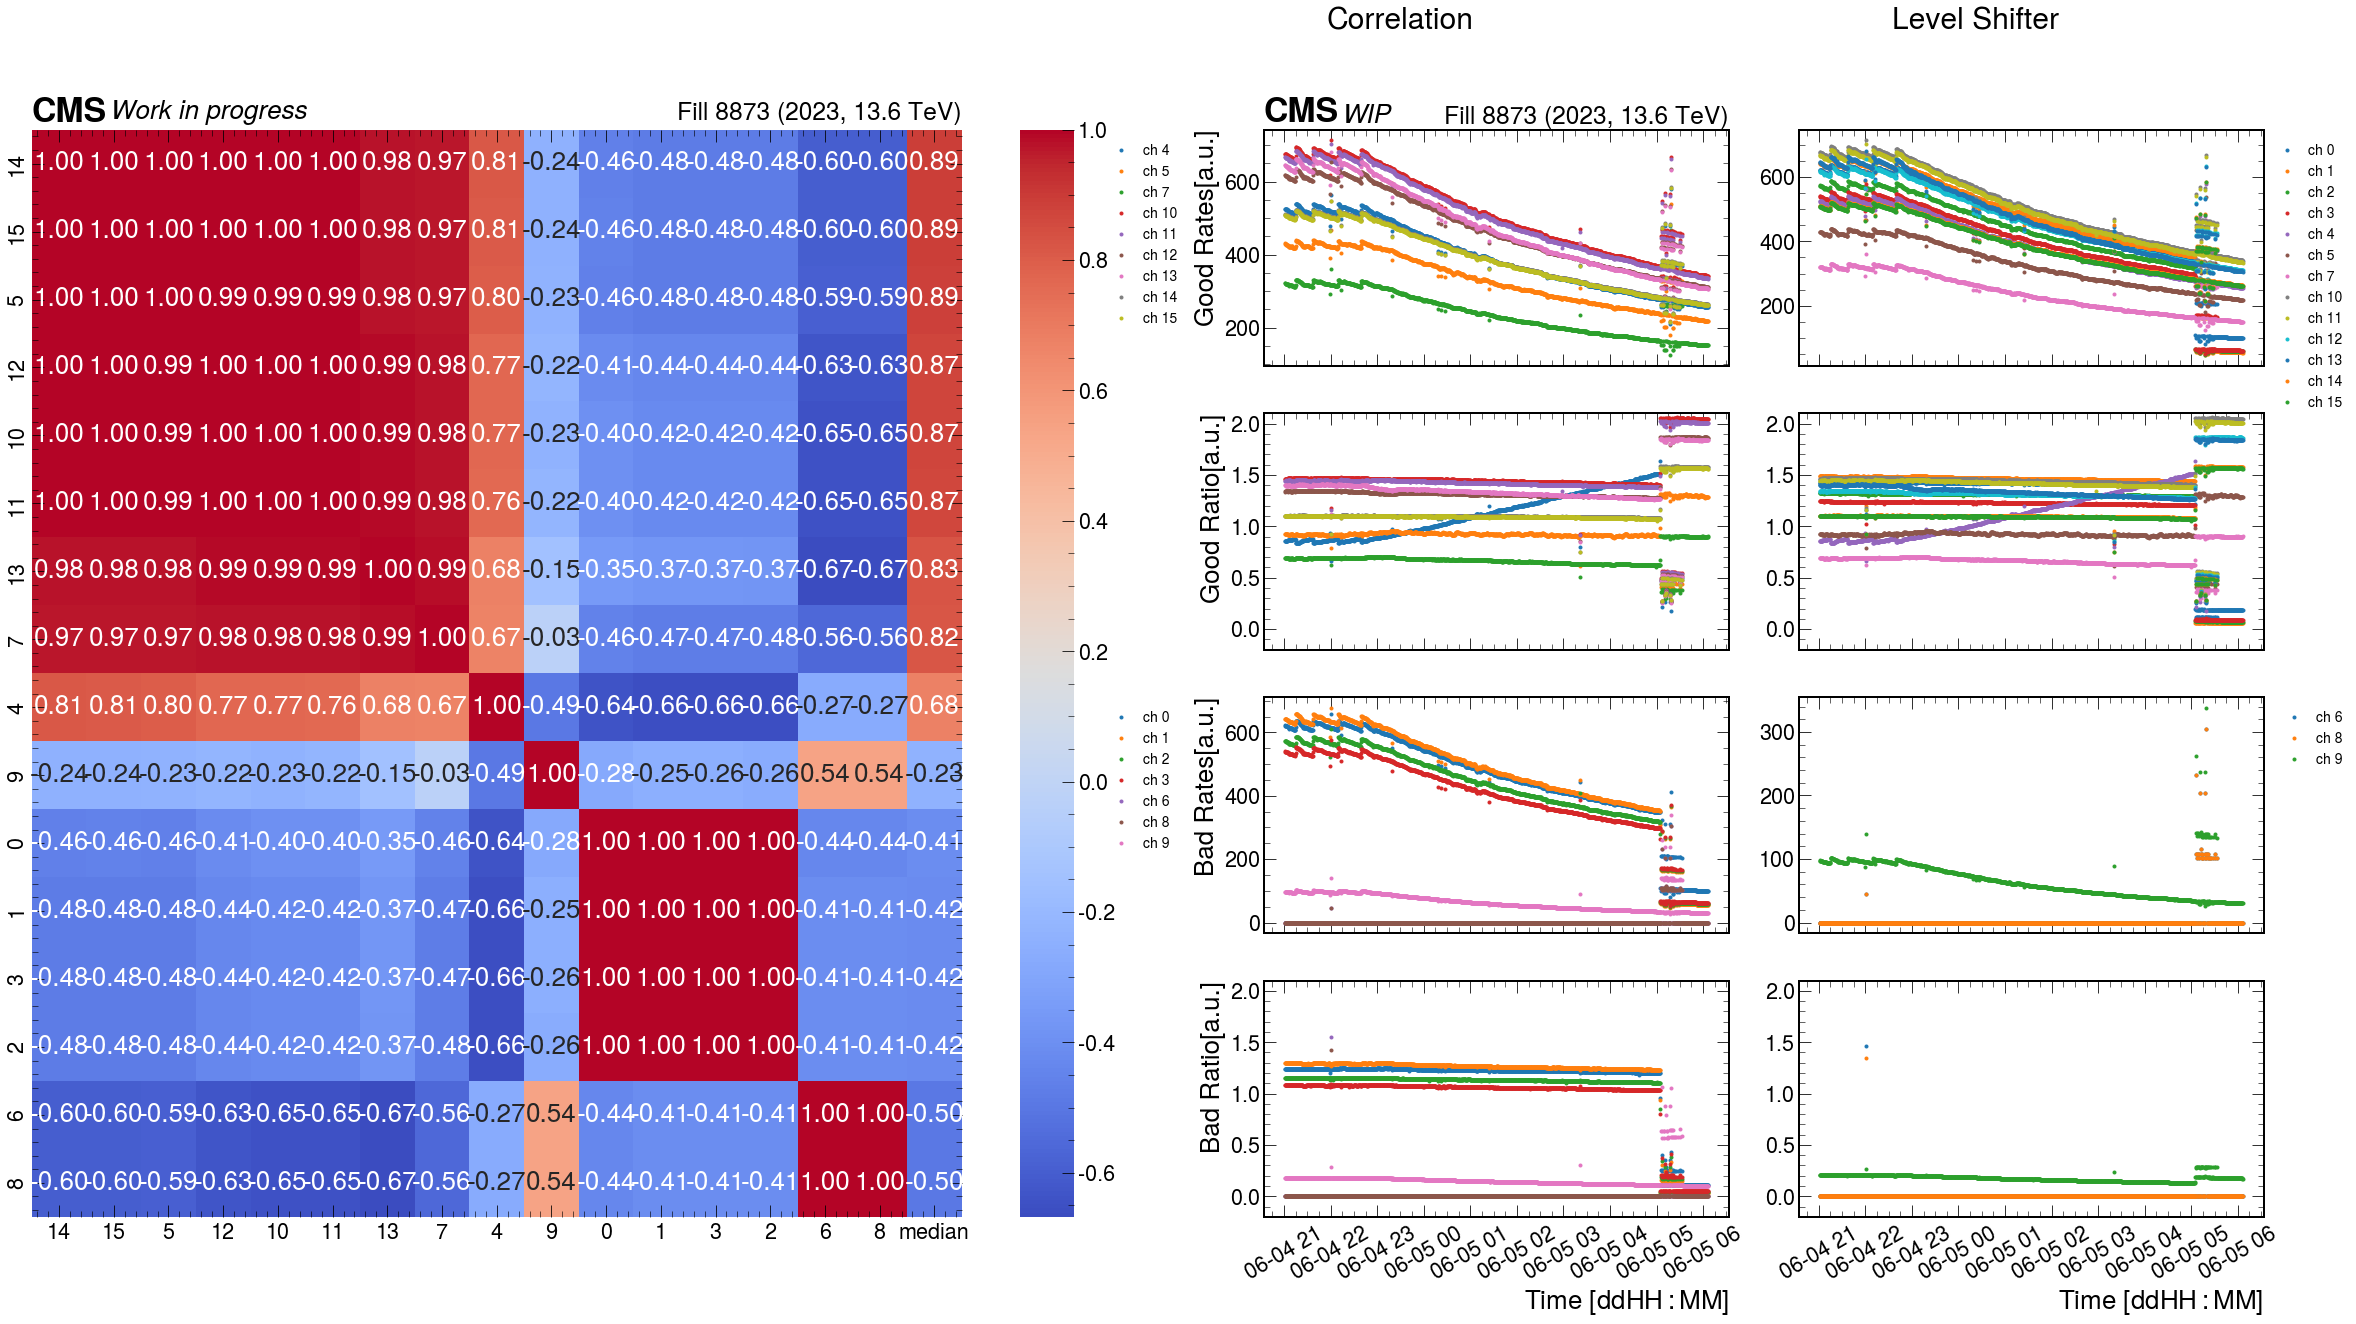

In [22]:
fill_number = 8873
year = 2023
mainpath = "/eos/user/t/tatehort/nonlinearity"
plt_path = f'{mainpath}/{year}_{fill_number}_plt'
#plt_path= f"{mainpath}/{fill_number}"
dt_pickles_path = f'{mainpath}/{year}_{fill_number}_dt_'

searcher = Processor()
df, rates_df_lin, ratio_lin = searcher(pickles_path_plt = plt_path,
#df = searcher(pickles_path_plt = plt_path,
                                   pickles_path_dt = dt_pickles_path,
                                   fill_number = fill_number,
                                   year = year,
                                   corrs_path = '/eos/user/t/tatehort/nonlinearity/corrs_all.json',
                                   store_path = '.')

In [ ]:
df

In [ ]:
df

In [ ]:
complete_df = searcher('/eos/user/t/tatehort/pylaf/parquets_fills/7921_complete.csv')
complete_df

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (18, 8))
for ch in complete_df.columns:
    complete_df[ch] = complete_df[ch]/ complete_df[ch].mean()
    sns.lineplot(data=df[ch], label=ch, ax = ax[0])
    sns.lineplot(data=complete_df[ch], label=ch, ax = ax[1])